In [45]:
import pickle

import sympy as sp
from sympy import cos, sin
from IPython.display import display, Math
sp.init_printing()


##### Compute linearized dynamics of the system about an arbitrary point.

We will use these dynamics to implement simulate the system and to make controllers. Equtions of motion taken from

https://se.mathworks.com/help/symbolic/derive-and-simulate-cart-pole-system.html

https://en.wikipedia.org/wiki/Inverted_pend

Nonlinear dynamics


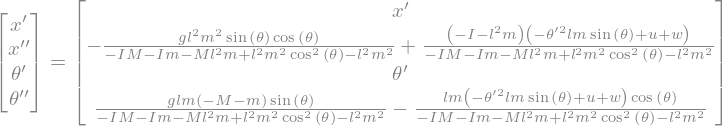

Linear dynamics


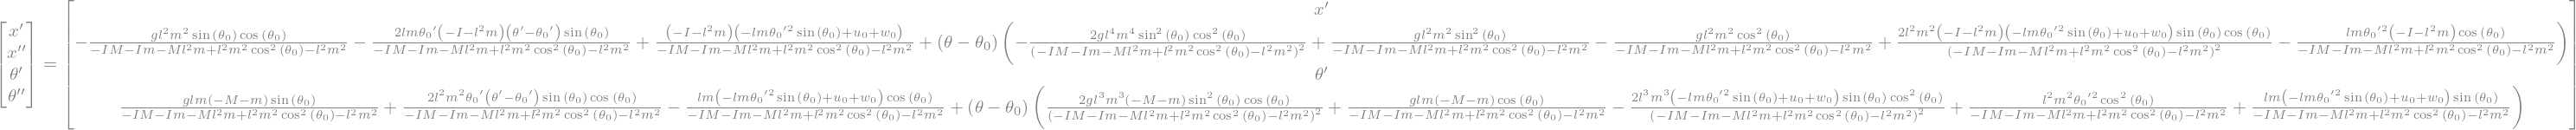

In [46]:
x, x_d, x_dd, th, th_d, th_dd = sp.symbols('x x\' x\'\' \\theta \\theta\' \\theta\'\'')   # x, x_dot, x_ddot, theta, theta_dot, theta_ddot
m, M , l, I, g, w, u = sp.symbols('m M l I g w u')
F = u + w                           # control action + disturbance

# Calculate a direct expression for the derivatives. x_dot and theta_dot
# already known as they are part of our state, only x_ddot and theta_ddot left

# Nonlinear dynamics for d = (x_ddot, theta_ddot), A*d' = B*d
A = sp.Matrix([
    [M + m,                  -l * m * cos(th)],
    [-l * m * cos(th),     m * l ** 2 + I]
])

b = sp.Matrix([
    -l * m * sin(th) * th_d ** 2 + F,
    g * l * m * sin(th)
])

# Compute d = (x_ddot, th_ddot) = A^-1 * b
d = A.inv() * b

# Build the full state vector z
z = sp.Matrix([x, x_d, th, th_d])
z_d = sp.Matrix([x_d, x_dd, th_d, th_dd])

# dz/dt = f(z, t), f is nonlinear
f = sp.Matrix([x_d, d[0], th_d, d[1]])
print('Nonlinear dynamics')
display(sp.Eq(z_d, f))

# In the linearization process we will need to pick a linearization point
# for our state z AND our inputs u and w
x0, x0_d, th0, th0_d, u0, w0 = sp.symbols('x_0 {x_0}\' \\theta_0 {\\theta_0}\' u_0 w_0')
z0 = sp.Matrix([x0, x0_d, th0, th0_d])
# Create the vector q for all the states we for which we insert a linearization point
# We ignore the derivates wrt. u and w, they are not interesing
q = sp.Matrix([*z, u, w])
q0 = sp.Matrix([*z0, u0, w0])

# Formula for linearization for f(x) wrt. x: f(x) = f(x0) + f'(x0)(x - x0)
f_linearized = f.subs(zip(q, q0)) + f.jacobian(z).subs(zip(q, q0))*(z-z0)
print('Linear dynamics')
display(sp.Eq(z_d, f_linearized))


Jacobian wrt. the control action: df / du


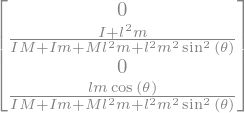

Jacobian wrt. the states: df / dz


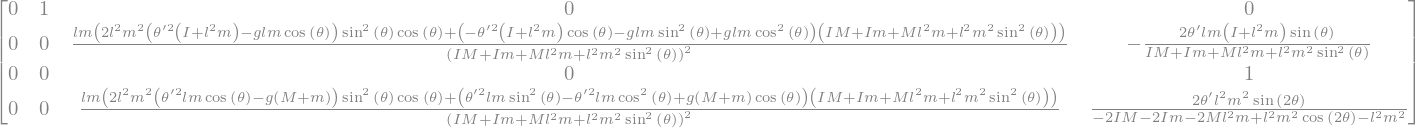

In [47]:
# In reality, we are not interested in the full linearization, only
# the derivatives with respect to our state and control action.
# In addition, w will be chosen as 0
g = f.subs([(w, 0)])

df_du = g.jacobian([u]); df_du.simplify()
print('Jacobian wrt. the control action: df / du')
display(df_du)

# In addition, when considering the jacobian wrt. the states
# u will be chosen as 0
g = f.subs([(w, 0), (u, 0)])
df_dz = g.jacobian(z); df_dz.simplify()
print('Jacobian wrt. the states: df / dz')
display(df_dz)



##### Export the nonlinear dynamics $f$, jacobians $\frac{df}{dz}$ and $\frac{df}{du}$ in order for us to use those equtions in the simulation

In [48]:

pkl_path = 'cart_pole/dynamics.pkl'

all_symbols = set()
all_symbols.update(f.free_symbols)
all_symbols.update(df_dz.free_symbols)
all_symbols.update(df_du.free_symbols)


with open(pkl_path, 'wb') as outfile:
    pickle.dump({'f': f, 'df_dz': df_dz, 'df_du': df_du, 'state_symbols': z,
                 'state_dot_symbols': z_d, 'u_symbol': u, 'w_symbol': w,
                 'func_symbols': all_symbols}, outfile)

print('Symbols in f')
display(f.free_symbols)
print('Symbols in df/dz')
display(df_dz.free_symbols)
print('Symbols in df/du')
display(df_du.free_symbols)
print('All symbols in functions')
display(all_symbols)

Symbols in f


Symbols in df/dz


Symbols in df/du


All symbols in functions


Usually we will want to linearize about $\theta=0$ and $\dot{\theta}=0$ if we want to use the linearized dynamics for a regulator

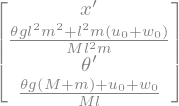

In [49]:
g = f_linearized.subs([(th0, 0), (th0_d, 0)])
g.simplify()
g = g.subs([(I, 0)])        # This is additional inertia about the COM of the pole, which many sources assume 0
g

This lines up with the expression for the linearized dynamics found in other sources.

e.g. https://courses.ece.ucsb.edu/ECE594/594D_W10Byl/hw/cartpole_eom.pdf
